In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings("ignore")

from hlpr_func import lat_mean, sindeg, calc_trend_HAC, get_weights_values

In [4]:
aqua = xr.open_dataset("MODIS_AOD/Aqua_aod_hist.nc").rename_vars({"aod_mean":"aqua_aod_mean","aod_hist":"aqua_aod_hist"})
era = xr.open_dataset("ERA5-CAMS/era5-interpolated.nc")[["landmask"]]
modis = xr.merge([aqua,era])

# select SO region
ds = modis.sel(lat=slice(-75,-45)).where(modis.landmask==0)
# make fake time coord
ds = ds.assign_coords({"month_since_start": ("time", np.arange(len(ds.time.values)))})
# select DJF
ds = ds.where(ds.time.dt.month.isin([12,1,2]))
# remove austrailian bush fires (Dec 2019 - Mar 2020)
ds = ds.where(~(ds.time.dt.year.isin(2019) & ds.time.dt.month.isin(12)))
ds = ds.where(~(ds.time.dt.year.isin(2020) & ds.time.dt.month.isin([1,2])))
# drop landmask
ds = ds[["aqua_aod_mean"]]
ds

<xarray.Dataset> Size: 13MB
Dimensions:            (lat: 30, lon: 360, time: 295)
Coordinates:
  * lat                (lat) float32 120B -74.5 -73.5 -72.5 ... -46.5 -45.5
  * lon                (lon) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * time               (time) datetime64[ns] 2kB 2000-03-15 ... 2024-09-15
    month_since_start  (time) int64 2kB 0 1 2 3 4 5 ... 289 290 291 292 293 294
Data variables:
    aqua_aod_mean      (lat, lon, time) float32 13MB nan nan nan ... nan nan nan

In [5]:
# add weights
weights = ds.time.dt.days_in_month
weights = weights.where(weights.time.dt.month!=2, 28.65)
ds["days_in_month"] = weights

climatology = ds.groupby("time.month").mean("time")
deseasonalized = ds.groupby("time.month") - climatology + climatology.weighted(climatology.days_in_month).mean("month")
deseasonalized = ds.assign_coords({"month_since_start": ("time", np.arange(len(deseasonalized.time.values)))})

so = lat_mean(deseasonalized.mean("lon"))
da = so.aqua_aod_mean.dropna(dim="time")
t = da.month_since_start.values
y = da.values
_, trend, trend_pm = calc_trend_HAC(t, y, hac_maxlags=12)
print("aqua aod trend")
print(trend*120, trend_pm*120)

aqua aod trend
0.013421067858488012 0.004280007199673265


In [6]:
# terra = xr.open_dataset("MODIS_AOD/Terra_aod_hist.nc").rename_vars({"aod_mean":"terra_aod_mean","aod_hist":"terra_aod_hist"})[["terra_aod_hist"]]
aqua = xr.open_dataset("MODIS_AOD/Aqua_aod_hist.nc").rename_vars({"aod_mean":"aqua_aod_mean","aod_hist":"aqua_aod_hist"})
era = xr.open_dataset("ERA5-CAMS/era5-interpolated.nc")[["landmask"]]
modis = xr.merge([aqua,era])

# select SO region
modis_so = modis.sel(lat=slice(-75,-45)).where(modis.landmask==0)
# make fake time coord
modis_so = modis_so.assign_coords({"month_since_start": ("time", np.arange(len(modis_so.time.values)))})
# select DJF
modis_so = modis_so.where(modis_so.time.dt.month.isin([12,1,2]))
# remove austrailian bush fires (Dec 2019 - Mar 2020)
modis_so = modis_so.where(~(modis_so.time.dt.year.isin(2019) & modis_so.time.dt.month.isin(12)))
modis_so = modis_so.where(~(modis_so.time.dt.year.isin(2020) & modis_so.time.dt.month.isin([1,2])))
# drop landmask
modis_so = modis_so[["aqua_aod_hist"]]
modis_so

<xarray.Dataset> Size: 127MB
Dimensions:            (aod_bins: 5, lat: 30, lon: 360, time: 295)
Coordinates:
  * lat                (lat) float32 120B -74.5 -73.5 -72.5 ... -46.5 -45.5
  * lon                (lon) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * aod_bins           (aod_bins) float32 20B 0.05 0.2 0.45 1.05 3.25
  * time               (time) datetime64[ns] 2kB 2000-03-15 ... 2024-09-15
    month_since_start  (time) int64 2kB 0 1 2 3 4 5 ... 289 290 291 292 293 294
Data variables:
    aqua_aod_hist      (aod_bins, lat, lon, time) float64 127MB nan nan ... nan

In [7]:
def sample_from_data(hist_values, bins, n):
    bin_logmidpoints = np.exp((np.log(bins[:-1]) + np.log(bins[1:]))/2)
    cdf = np.cumsum(hist_values, axis=0)
    cdf = cdf / cdf[-1] # normalize

    nmax = np.max(n)
    random_from_cdf = np.nan * np.zeros((nmax, *np.shape(cdf)[1:]))
    for lati in np.arange(np.shape(cdf)[1]):
        for loni in np.arange(np.shape(cdf)[2]):
            if not np.isnan(np.sum(cdf[:,lati,loni])):
                values = np.random.rand(n[lati,loni])
                nvalues = len(values)
                value_bins = np.searchsorted(cdf[:,lati,loni], values)
                random_from_cdf[:nvalues,lati,loni] = bin_logmidpoints[value_bins]

    return random_from_cdf

def sample_aod_ts(ds_modis, sampling_factor=1200):
    bins = np.append(ds_modis.aod_bins, 10)
    aod_mean_sampled = np.zeros((len(ds_modis.time), len(ds_modis.lat), len(ds_modis.lon)))
    
    for ti in np.arange(len(ds_modis.time)):
        hist = ds_modis.isel(time=ti).aqua_aod_hist
        n_per_grid_float = hist.sum("aod_bins").values / sampling_factor
        n_per_grid = np.where(n_per_grid_float < 1, np.random.rand(1) < n_per_grid_float, np.round(n_per_grid_float)).astype(int)
        samples = sample_from_data(hist.values, bins, n_per_grid)
        
        aod_mean_sampled[ti,:,:] = np.nanmean(samples, axis=0)
    
    ds_sampled = xr.Dataset(
        data_vars = {
            "aod_mean_sampled": (("time","lat","lon"), aod_mean_sampled)
        },
        coords = {
            "time":ds_modis.time,
            "lat":ds_modis.lat,
            "lon":ds_modis.lon
        }
    )
    return ds_sampled

def sampled_aod_so_trend(ds_sampled):
    climatology = ds_sampled.groupby("time.month").mean("time")
    deseasonalized = ds_sampled.groupby("time.month") - climatology + climatology.mean("month")
    deseasonalized = deseasonalized.assign_coords({"month_since_start": ("time", np.arange(len(deseasonalized.time.values)))})

    so = lat_mean(deseasonalized.mean("lon"))
    da = so.aod_mean_sampled.dropna(dim="time")
    t = da.month_since_start.values
    w = get_weights_values(da)
    _, trend, trend_pm = calc_trend_HAC(t, da.values, w, hac_maxlags=12)
    
    return trend*120, trend_pm*120 # units = 1/decade

In [8]:
nbootstrap = 100
sampling_factor = 1200
trend_bootstrap, SE_bootstrap = np.zeros(nbootstrap), np.zeros(nbootstrap)
for i in np.arange(nbootstrap):
    ds_sampled = sample_aod_ts(modis_so, sampling_factor)
    trend_bootstrap[i], SE_bootstrap[i] = sampled_aod_so_trend(ds_sampled)
    print(i, trend_bootstrap[i])

np.savetxt(f"MODIS_AOD/trend_weighted_bootstrap_n{nbootstrap}_freq{sampling_factor}.csv", trend_bootstrap, delimiter=',') 
np.savetxt(f"MODIS_AOD/error_weighted_bootstrap_n{nbootstrap}_freq{sampling_factor}.csv", SE_bootstrap, delimiter=',') 

0 0.004704773739592331
1 0.007983157977922884
2 0.009700840819581035
3 0.010036851238236853
4 0.0030505112715148
5 0.020231551129990623
6 0.014499502962618867
7 0.007053464646387045
8 0.008624650284244686
9 -0.008547228460948336
10 0.0259052735097116
11 0.007428784614579013
12 0.004020575005035119
13 0.009752694463588708
14 0.002793551257988661
15 0.014888351757292794
16 0.015095157695965864
17 0.01845652558903304
18 -0.03420716258885499
19 0.014637213504365438
20 0.01679559055010416
21 0.01803699599370416
22 0.0021971151610057677
23 0.01976987715074191
24 0.01406648994801103
25 0.015541249393550734
26 0.0012075057467123224
27 0.020726457155861373
28 0.03072698710863679
29 0.028235778422970582
30 0.01982651696933907
31 -0.006243248149673621
32 0.019589350905982076
33 0.00511102180053275
34 0.03193334160887093
35 0.008252652489199968
36 0.008452806615296873
37 0.013214125578710025
38 0.017884372302757915
39 0.011938715288995417
40 0.011950346176347458
41 0.00798815079752652
42 0.0151088

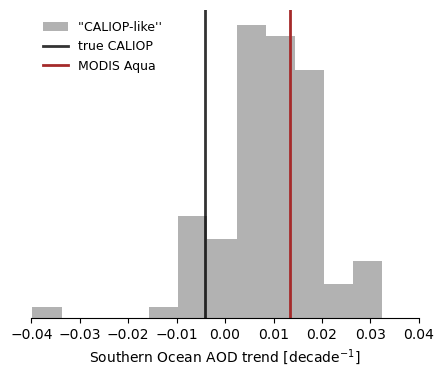

In [22]:
trend_bootstrap = np.loadtxt("MODIS_AOD/trend_weighted_bootstrap_n100_freq1200.csv")

fig,ax = plt.subplots(1,1,figsize=(5,4))
plt.hist(trend_bootstrap, bins=30, color="k", alpha=0.3, label="''CALIOP-like''")

ax.axvline(-0.0042, color="k", alpha=0.8, lw=2, label="true CALIOP")
ax.axvline(0.0134, color="brown", lw=2, label="MODIS Aqua")

ax.legend(frameon=False, loc="best", fontsize=9)
ax.set_xlabel("Southern Ocean AOD trend [decade$^{-1}$]")

ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlim(-0.04, 0.04)
# ax.axvline(0, lw=0.5, color="k")

plt.savefig("paper-figures/bootstrap100_freq1200_aod_trends.png", dpi=200, facecolor="w", bbox_inches="tight")
plt.show()